In [16]:
import sys
sys.path.insert(0, '/home/cameron/Projects/hypso-package')

from hypso import Hypso1
import os
import numpy as np
from pyproj import Transformer
from pyproj import Proj
from pyresample import geometry
import satpy
from satpy.composites import GenericCompositor
from satpy.writers import to_image

from PIL import Image
from pycoast import ContourWriterAGG

dir_path = '/home/cameron/Nedlastinger'
l1a_nc_file = os.path.join(dir_path, 'griegloppa_2024-08-20T09-23-59Z-l1a.nc')
points_file = os.path.join(dir_path, 'sift-bin.points')

l1a_nc_file = os.path.join(dir_path, 'northaustralia1_2024-08-25T01-21-54Z-l1a.nc')
points_file = os.path.join(dir_path, 'northaustralia1_2024-08-25T01-21-54Z-l1a.points')

l1a_nc_file = os.path.join(dir_path, 'adelaide_2024-08-24T00-18-34Z-l1a' + '.nc')
points_file = os.path.join(dir_path, 'adelaide_2024-08-24T00-18-34Z-l1a' + '.points')


l1a_nc_file = os.path.join(dir_path, 'virginiabeach_2024-08-22T14-59-41Z-l1a' + '.nc')
points_file = os.path.join(dir_path, 'virginiabeach_2024-08-22T14-59-41Z-l1a' + '.points')





satobj = Hypso1(path=l1a_nc_file, points_path=points_file, verbose=True)
satobj.load_points_file(path=points_file, image_mode='standard', origin_mode='cube')

satobj.generate_georeferencing()
#satobj.generate_geometry()
satobj.generate_l1b_cube()

bbox = satobj.get_bbox()
print(bbox)

[INFO] Loading L1a capture virginiabeach_2024-08-22T14-59-41Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 18N EPSG: 32618
[INFO] Running georeferencing...
[INFO] Using UTM map: WGS 84 / UTM zone 18N EPSG: 32618
[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...
(-77.00632972163866, 35.52002969100794, -75.21735995250224, 38.89471781906347)


In [17]:
area_id = satobj.capture_target
proj_id = 'roi'
description = 'roi'

lon_0 = (bbox[2] - bbox[0])/2 + bbox[0]
lat_ts = (bbox[3] - bbox[1])/2 + bbox[1]

p = Proj(proj="stere", ellps="bessel", lat_0=90.0, lon_0=lon_0, lat_ts=lat_ts)

projection = {"proj": "stere", 
              "ellps": "bessel", 
              "lat_0": 90.0, 
              "lon_0": lon_0, 
              "lat_ts": lat_ts, 
              "units": "m"}

lower_left_x, lower_left_y = p(bbox[0], bbox[1])
upper_right_x, upper_right_y = p(bbox[2], bbox[3])
area_extent = (lower_left_x, lower_left_y, upper_right_x, upper_right_y)

res = 300 #meters

width = (area_extent[2] - area_extent[0]) / res
height = (area_extent[3] - area_extent[1]) / res

area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)



In [18]:
l1a_scene = satobj.get_l1a_satpy_scene()
l1b_scene = satobj.get_l1b_satpy_scene()

resampled_scene = l1b_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [19]:
# RGB Hypso image
compositor = GenericCompositor("rgba")

try:
    red_wl = 630
    green_wl = 550
    blue_wl = 480

    red_idx = satobj.get_closest_wavelength_index(red_wl)
    green_idx = satobj.get_closest_wavelength_index(green_wl)
    blue_idx = satobj.get_closest_wavelength_index(blue_wl)

except:
    red_idx = 69
    green_idx = 46
    blue_idx = 26

red_band = 'band_' + str(red_idx)
green_band = 'band_' + str(green_idx)
blue_band = 'band_' + str(blue_idx)
alpha_band = 'band_' + str(blue_idx)

composite = compositor([resampled_scene[red_band], resampled_scene[green_band], resampled_scene[blue_band], resampled_scene[alpha_band]]) 

rgb_img = to_image(composite) 
rgb_img.stretch_linear()
rgb_img.gamma(2)

rgb_xr_image = rgb_img

rgb_img = rgb_img.pil_image()

In [20]:
size = (area_def.shape[1], area_def.shape[0])

# Base image
base_img = Image.new(mode="RGBA", size=size, color=(173, 216, 230))
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(base_img, area_def, resolution='f', outline='black', fill='gray')

# Overlay image
overlay_img = Image.new(mode="RGBA", size=size)
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(overlay_img, area_def, resolution='f', outline='black', level=4)
cw.add_rivers(overlay_img, area_def, level=10, outline='blue', resolution='f')
cw.add_borders(overlay_img, area_def, outline=(255, 0, 0))


combined_img = Image.alpha_composite(base_img, rgb_img)
combined_img = Image.alpha_composite(combined_img, overlay_img)
combined_img.save('./' + satobj.capture_name + '_rgb_decorated.png')

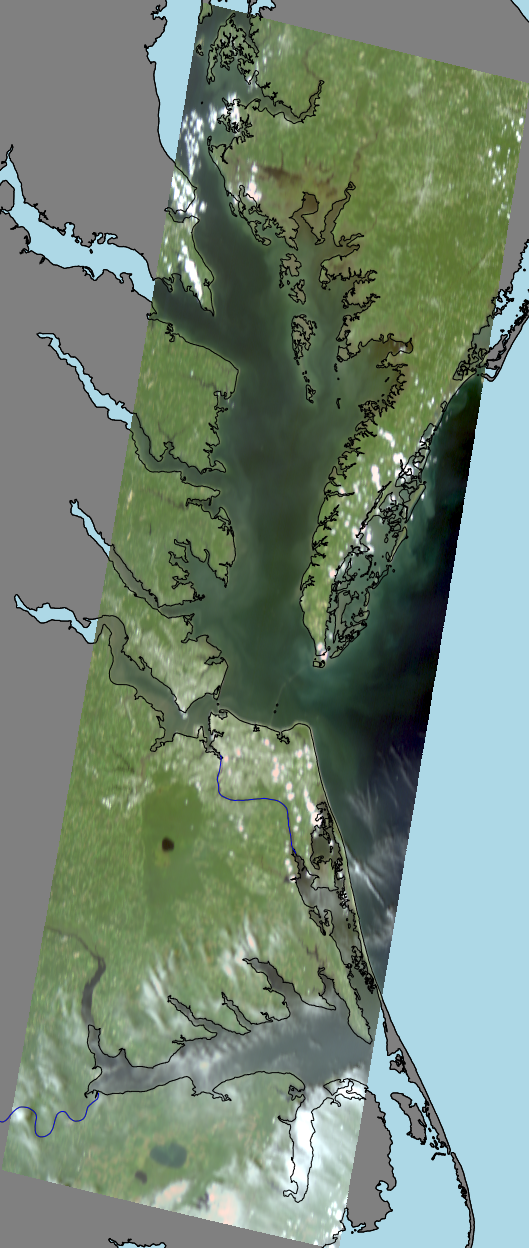

In [21]:
combined_img